<a href="https://colab.research.google.com/github/Onabanjomicheal/predicting-mobility-demand/blob/main/Predicting_Mobility_Demand_From_Urban_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project explores how urban features—like the distribution of shops and services—relate to bike-sharing demand. Using a dataset of shared bike trips in Shenzhen, we analyze the number of trips that end in each neighborhood and tally the nearby points of interest (POIs), such as healthcare facilities, transport hubs, and other services. We then use linear regression and a graph neural network to model the relationship between the density of POIs and the density of trip endpoints.

In [ ]:
import os
from pathlib import Path
import shutil
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

%matplotlib inline

In [ ]:
!pip install geopandas
!pip install openpyxl
!pip install h3pandas
!pip install shap
!pip install mapclassify

import openpyxl
import geopandas as gpd
import h3pandas
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
# GNN libraries

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.7 MB/s eta 0:00:00


In [1]:
#!gdown --folder --remaining-ok https://drive.google.com/drive/u/3/folders/1sLp2mWlBMX3mRnkTAzHcMBStCXLK2KDN -O /content/data/

The trip start and end data are stored in csv files within a compressed file called shared_bike_data.zip. We start by unzipping the file.

In [ ]:
!unzip '/content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data.zip' -d '/content/data/Shenzhen Bike-Share Data/8.01-8.30/'

Archive:  /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data.zip
   creating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/._shared_bike_data  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/21_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._21_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/22_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._22_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/24_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/__MACOSX/shared_bike_data/._24_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/23_1000w.csv  
  inflating: /content/data/Shenzhen Bike-Share Data/8.01-

The shape files that define points of interest (POIs) are stored in a compressed file called ShapeFile.zip. POIs are urban features such as restaurants, hospitals, bus stations, stadiums, etc. The shape files store spatial information about the POIs, for example, their latitude and longitude coordinates.

In [ ]:
!unzip '/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile.zip' -d '/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/'

Archive:  /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile.zip
   creating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/._ShapeFile  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_MotorcycleService_20220602_033442.dbf  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_MotorcycleService_20220602_033442.dbf  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_AutoRepair_20220602_033427.cpg  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_AutoRepair_20220602_033427.cpg  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile/shenzhen_AutoRepair_20220602_033427.shp  
  inflating: /content/data/Shenzhen Bike-Share Data/ShenzhenPOI/__MACOSX/ShapeFile/._shenzhen_AutoRepair_20220602_033427.shp  
  inflating: /conten

## Data Preprocessing

Let's begin by loading a subset of the trip data to a pandas dataframe. We choose the csv file called 21_1000w.

Since the csv files have many rows of data, running this tutorial with all the data will be time-consuming. So we are working with a subset. If you are interested, it could be a good exercise to run this tutorial using all the data.

In [ ]:
df = pd.read_csv('/content/data/Shenzhen Bike-Share Data/8.01-8.30/shared_bike_data/21_1000w.csv')

In [ ]:
df.count()

,0
Unnamed: 0,9980998
_id,9980998
START_TIME,9980998
START_LAT,9980998
END_TIME,9980998
END_LNG,9980998
USER_ID,9980998
START_LNG,9980998
END_LAT,9980998


As you can see, the dataframe has close

*   List item
*   List item

to 10 million entries! In this project we will work with a sample of 100,000 entries. This will allow the model to train within a reasonable amount of time.

In [ ]:
df = df.sample(150000).reset_index(drop=True)

Next, let's take a look at what attributes our trip data has by printing the first couple of rows.

In [ ]:
df.head()

,Unnamed: 0,_id,START_TIME,START_LAT,END_TIME,END_LNG,USER_ID,START_LNG,END_LAT
0,5355594,6235f423d9eb0867d7d4d7f0,2021-08-03 22:04:22.0,22.686343,2021-08-03 22:21:14.0,114.242046,c544d5956db7dddc863ec0**********,114.251128,22.682645
1,1968097,6235e336d9eb0867d7a12787,2021-08-01 18:19:03.0,22.747084,2021-08-01 20:00:57.0,113.839313,8d9b616624ab84242f0ea5**********,113.845122,22.766158
2,3717376,6235ed05d9eb0867d7bbd8a6,2021-08-03 01:21:27.0,22.600052,2021-08-03 01:24:30.0,114.114551,0b1c25d0004ac44e8d18c0**********,114.117940,22.599487
3,1230273,6235df27d9eb0867d795e567,2021-08-01 10:19:16.0,22.558187,2021-08-01 10:23:18.0,114.242635,9466effd4986be44b2c4bd**********,114.237656,22.559838
4,9309488,623606e7d9eb0867d7112cd6,2021-08-07 08:13:28.0,22.704526,2021-08-07 08:25:37.0,113.820450,0dac43c89ae35299586aae**********,113.824662,22.718074


We can see that the data consists of start and end times and coordinates of the trips. Next, let's print out the range, min and max of each attribute:

In [ ]:
pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,150000,72,9980982
_id,150000,6235d85fd9eb0867d7831fee,62360a21d9eb0867d71b6bdc
START_TIME,150000,2021-07-28 07:51:11.0,2021-08-07 19:07:15.0
START_LAT,150000,0.0,47.660913
END_TIME,150000,2021-07-28 07:55:46.0,2021-08-07 19:12:08.0
END_LNG,150000,0.0,114.530432
USER_ID,150000,0000cb88f620dc4a5f6d20**********,ffffe4a8422aba3a422113**********
START_LNG,150000,0.0,132.535877
END_LAT,150000,0.0,22.90027


The summary above shows that our data is from the last four days of July 2021. We also notice that the some trips start and/or end at 0.0 coordinates. This is clearly erroneous since Shenzhen's longitude range is approximately between 113.7 to 114.7 and latitude range is between 22.0 and 23.0. We should drop all trips that start and end outside Shenzhen.

In [ ]:
# selecting approx coordinates around Shenzhen
longitude_range = [113.7, 114.7]
latitude_range = [22.0, 23.0]

col_to_range_map = {"START_LAT" : latitude_range,
                    "START_LNG" : longitude_range,
                    "END_LAT" : latitude_range,
                    "END_LNG" : longitude_range
                    }

for col, distance in col_to_range_map.items():
    df.drop(df[(df[col] > distance[1]) | (df[col] < distance[0])].index, inplace=True)

pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,149787,72,9980982
_id,149787,6235d85fd9eb0867d7831fee,62360a21d9eb0867d71b6bdc
START_TIME,149787,2021-07-28 07:51:11.0,2021-08-07 19:07:15.0
START_LAT,149787,22.422615,22.950335
END_TIME,149787,2021-07-28 07:55:46.0,2021-08-07 19:12:08.0
END_LNG,149787,113.774495,114.530432
USER_ID,149787,0000cb88f620dc4a5f6d20**********,ffffe4a8422aba3a422113**********
START_LNG,149787,113.755647,114.570005
END_LAT,149787,22.033868,22.90027


Since we might expect variations in trip densities depending on time of day and day of week, we will add a couple of columns to the dataframe to represent these features.

To do that, we first need to convert the start and end time attributes in the dataframe to datetime objects so that they can be compared with other dates.

In [ ]:
#Convert the start and end time columns in the data frame to datetime objects
df['START_TIME'] = pd.to_datetime(df['START_TIME'])
df['END_TIME'] = pd.to_datetime(df['END_TIME'])

Now we can analyse the temporal distribution of the data over the days of a week and over the time of a day

Text(0.5, 0.98, 'Distribution of trips over the week (left) and per hour of a day (right)')

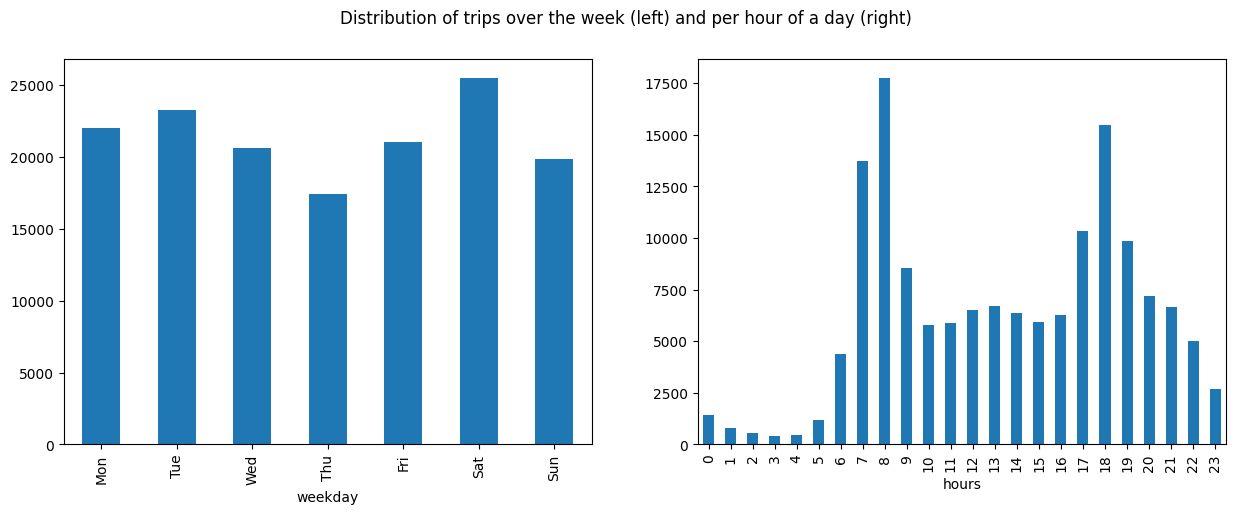

In [ ]:
weekday_names = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun',}
order = weekday_names.values()

df['weekday'] = df['START_TIME'].dt.dayofweek
df['weekday'] = df['weekday'].replace(weekday_names)
df['hours'] = df['START_TIME'].dt.hour

weekdays = df.groupby('weekday').size().to_frame('count').loc[order].reset_index()
hours = df.groupby('hours').size().to_frame('count').reset_index()

fig,ax = plt.subplots(ncols=2, figsize=(15,5))
weekdays.plot.bar(ax=ax[0], x='weekday',y='count',legend = False)
hours.plot.bar(ax=ax[1], x='hours',y='count',legend=False)
plt.suptitle('Distribution of trips over the week (left) and per hour of a day (right)')

We will add a column for whether a trip occurs on a weekday or the weekend.

In [ ]:
# Add weekday column
df.loc[:, 'IS_WEEKDAY'] = df['START_TIME'].dt.dayofweek < 5

In [ ]:
pd.DataFrame({
    'count': df.count(),
    'min': df.min(),
    'max': df.max()
})

,count,min,max
Unnamed: 0,149787,72,9980982
_id,149787,6235d85fd9eb0867d7831fee,62360a21d9eb0867d71b6bdc
START_TIME,149787,2021-07-28 07:51:11,2021-08-07 19:07:15
START_LAT,149787,22.422615,22.950335
END_TIME,149787,2021-07-28 07:55:46,2021-08-07 19:12:08
END_LNG,149787,113.774495,114.530432
USER_ID,149787,0000cb88f620dc4a5f6d20**********,ffffe4a8422aba3a422113**********
START_LNG,149787,113.755647,114.570005
END_LAT,149787,22.033868,22.90027
weekday,149787,Fri,Wed


Next, let's visualize the shape files in our dataset, starting with the shape file for Shenzhen.

In [ ]:
# Read shape file
shenzhen = gpd.read_file("data/Shenzhen Bike-Share Data/shenzhen/shenzhen.shp")

In [ ]:
shenzhen.head()

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.09969 22.535..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 113.98558 22.523..."
2,114.270206,22.596432,盐田,"POLYGON ((114.22772 22.5429, 114.22643 22.5436..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81816 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.98587 22.80304, 113.98605 22.802..."


Text(214.51131188765714, 0.5, 'Latitude')

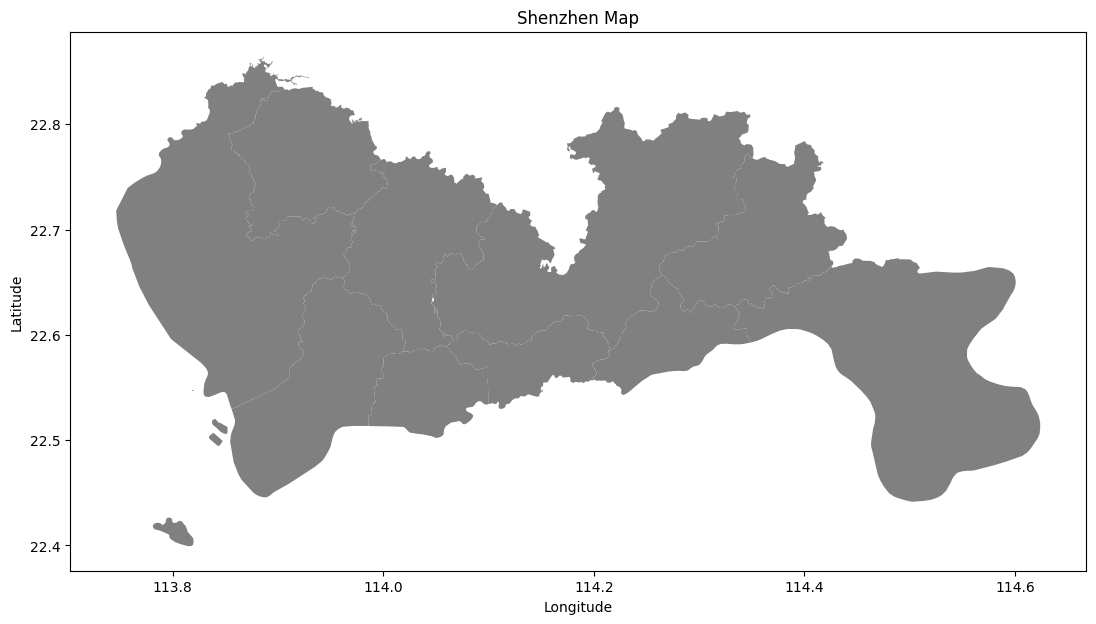

In [ ]:
# Visualize
fig,ax = plt.subplots(figsize=(15,7))
shenzhen.plot(ax=ax,color='gray')
ax.set_title('Shenzhen Map')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

We overlap the trip starting points and ending points on the map above. To do this, we will first need to create geodataframes from the trip start and end coordinates from the data we processed above. Then we will have to plot the trip start/end geodataframe along with the Shenzhen geodataframe. Luckily, our plot_shenzhen function handles all these steps, so we can call it with the columns corresponding to the trip starting positions and ending positions. This yields the two plots below:

In [ ]:
# Create geopandas dataframes for start and end points separately
gdf_start = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df['START_LNG'], df['START_LAT'])],crs=4326)
gdf_end = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df['END_LNG'], df['END_LAT'])],crs=4326)

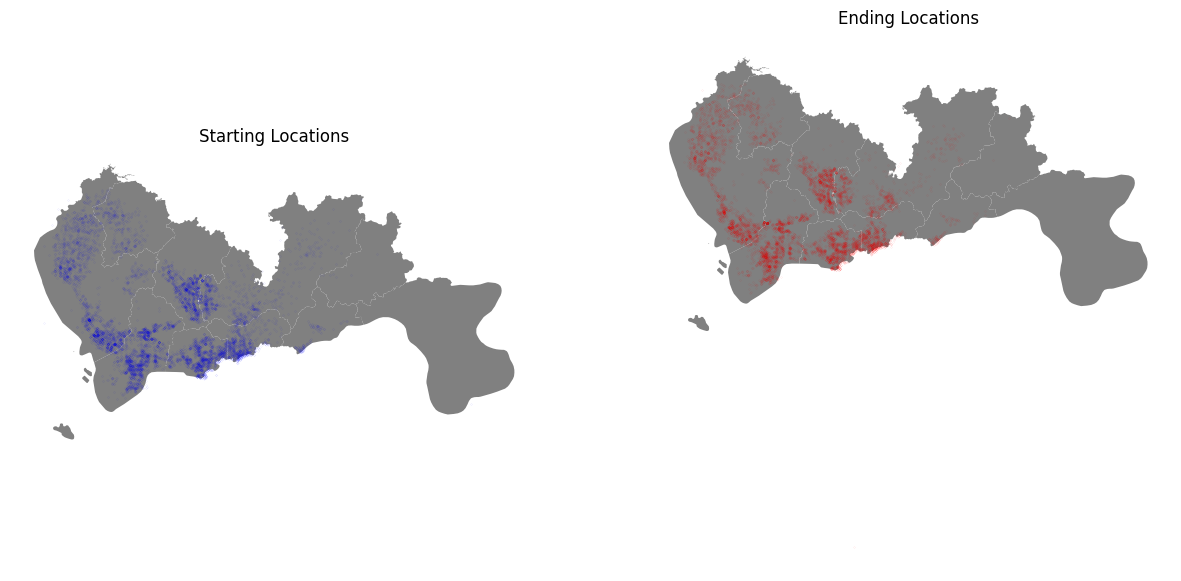

In [ ]:
# Visualize Starting Locations
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
shenzhen.plot(ax=ax[0],color='gray')
gdf_start.sample(10000).plot(ax=ax[0],color='blue',marker='o',markersize=0.001)
ax[0].set_title('Starting Locations')
ax[0].set_axis_off()

shenzhen.plot(ax=ax[1],color='gray')
gdf_end.sample(10000).plot(ax=ax[1],color='red',marker='o',markersize=0.001)
ax[1].set_title('Ending Locations')
ax[1].set_axis_off()


*Notice that the start and end plots look similar. In fact what we are plotting here are actually bike stands from which bikers borrow and return bikes. We can now investigate the POIs (restaurants, stadiums, offices, stations, etc.) that exist around these bike stands to get a sense for where the bikers are headed.*

The process of loading and visualizing the POI data from shape files is similar to above. Again, since loading all the POI shape files and plotting them will be time-consuming, we load a subset of the POI categories.   
Before we can select the POI categories we are interested in, we need to find out what POI categories exist. This information is stored in the amap_poicode.xlsx file in the ShenzhenPOI folder.

In [ ]:
# Find all POI types
poi_types_df = pd.read_excel("data/Shenzhen Bike-Share Data/ShenzhenPOI/amap_poicode.xlsx")
poi_types_df.head(10)

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,序号,NEW_TYPE,大类,中类,小类,Big Category,Mid Category,Sub Category
0,1,10000,汽车服务,汽车服务相关,汽车服务相关,Auto Service,Automobile Service Related,Automobile Service Related
1,2,10100,汽车服务,加油站,加油站,Auto Service,Filling Station,Filling Station
2,3,10101,汽车服务,加油站,中国石化,Auto Service,Filling Station,Sinopec
3,4,10102,汽车服务,加油站,中国石油,Auto Service,Filling Station,PetroChina
4,5,10103,汽车服务,加油站,壳牌,Auto Service,Filling Station,Shell
5,6,10104,汽车服务,加油站,美孚,Auto Service,Filling Station,Mobil
6,7,10105,汽车服务,加油站,加德士,Auto Service,Filling Station,Caltex
7,8,10107,汽车服务,加油站,东方,Auto Service,Filling Station,FEOSO
8,9,10108,汽车服务,加油站,中石油碧辟,Auto Service,Filling Station,BP PetroChina
9,10,10109,汽车服务,加油站,中石化碧辟,Auto Service,Filling Station,BP Sinopec


Each POI category is further sub-divided into smaller categories. Let's assume that we are not interested in the sub-categories. We will need to find all the unique categories stored in the "Big Category" attribute above.

In [ ]:
unique_poi_types = poi_types_df['Big Category'].drop_duplicates().values

print(unique_poi_types)

['Auto Service' 'Auto Dealers' 'Auto Repair' 'Motorcycle Service'
 'Food & Beverages' 'Shopping' 'Daily Life Service' 'Sports & Recreation'
 'Medical Service' 'Accommodation Service' 'Tourist Attraction'
 'Commercial House' 'Governmental Organization & Social Group'
 'Science/Culture & Education Service' 'Culture & Education'
 'Transportation Service' 'Finance & Insurance Service' 'Enterprises'
 'Road Furniture' 'Place Name & Address' 'Public Facility'
 'Incidents and Events' 'Indoor facilities' 'Pass Facilities']


Next, we have to sanitize the category names by removing whitespaces and some special characters. We have to do this because the shape file names corresponding to these categories contain sanitized category names and we want to  select the shape files for the categories we are interested in.

In [ ]:
for i, poi in enumerate(unique_poi_types):
  for c in [' ', '&', '/']:
     unique_poi_types[i] = unique_poi_types[i].replace(c, '')

print(unique_poi_types)

['AutoService' 'AutoDealers' 'AutoRepair' 'MotorcycleService'
 'FoodBeverages' 'Shopping' 'DailyLifeService' 'SportsRecreation'
 'MedicalService' 'AccommodationService' 'TouristAttraction'
 'CommercialHouse' 'GovernmentalOrganizationSocialGroup'
 'ScienceCultureEducationService' 'CultureEducation'
 'TransportationService' 'FinanceInsuranceService' 'Enterprises'
 'RoadFurniture' 'PlaceNameAddress' 'PublicFacility' 'IncidentsandEvents'
 'Indoorfacilities' 'PassFacilities']


In [ ]:
# Define POI categories we want to select
poi_cat = ['SportsRecreation', 'TransportationService', 'MedicalService']

In [ ]:
# Set path to shapefile directory
poi_dir_path = '/content/data/Shenzhen Bike-Share Data/ShenzhenPOI/ShapeFile'

# Load poi shape files
shp_files = []
for file_path in os.listdir(poi_dir_path):
  if file_path.endswith(".shp"):
    for cat in poi_cat:
      if cat in file_path:
        shp_file = gpd.read_file(os.path.join(poi_dir_path, file_path))
        shp_file['POI_TYPE'] = cat
        shp_files.append(shp_file)
        continue

In [ ]:
# Create geo dataframe from all POIs
poi_gdf = pd.concat(shp_files).pipe(gpd.GeoDataFrame)
poi_gdf.describe(include='all')

,geometry,POI_TYPE
count,80237,80237
unique,80009,3
top,POINT (113.96224097276098 22.70804055426153),TransportationService
freq,4,35387


To visually analyze the data we now use the "explore" function from geopandas. An easy way to quickly inspect geopandas geometries on any kind of basemap.

In [ ]:
poi_gdf.sample(1000).explore('POI_TYPE', tiles='CartoDB positron')

We have a good distribution of our selected POIs around the trip starting and ending points. So we can hope that we can model some kind of relationship between the trips and these POIs. But first, we have to save our POI geodataframe so that we can reuse it later.

In [ ]:
# Prepare directory to save poi geodataframe
compiled_poi_path = '/content/data/Shenzhen Bike-Share Data/poi_compiled'

# Delete folder if it already exists
if os.path.exists(compiled_poi_path):
  shutil.rmtree(compiled_poi_path)

os.mkdir(compiled_poi_path)

In [ ]:
# Save poi gdf
poi_gdf.to_file(compiled_poi_path + '/compiled.shp', encoding='UTF-8')

<a name="methodology"></a>
# Methodology

Our goal is to investigate the influence of POIs on trip destinations.

To do this, we first count the number of POIs and the number of trips ending in each location, and then regress the trip counts on the POI counts to study how they are related. We use Uber's hexagonal grid called [H3](https://github.com/uber/h3) and its add-on for (Geo)Pandas [h3pandas](https://h3-pandas.readthedocs.io/en/latest/index.html) and count the number of POIs and trips in each grid cell.

The great thing about H3 is that it has a unique indexing system around the world (i.e. the cell id `88411cd68dfffff` always corresponds to the same location) and supports multiple spatial resolutions (see [here](https://h3geo.org/docs/core-library/restable)). So we can try different grid sizes for our analysis and further aggregate the data with little additional effort. For the resolution `8` that we use, each grid cell has an area of [0.74 km2](https://h3geo.org/docs/core-library/restable#average-area-in-km2).

In [ ]:
!pip install h3pandas
# Restart the notebook kernel after running this cell

## POI and Trip Counts

In [ ]:
import h3pandas

# Convert trip DataFrame to a GeoDataFrame with the geometry describing the trip destination
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=gpd.points_from_xy(df['END_LNG'], df['END_LAT']))

# Create a hexagonal grid using Uber's H3 library and count the number of trips ending in each grid cell
trips = gdf[['_id', 'geometry']].h3.geo_to_h3_aggregate(resolution=8, operation='count')
trips = trips.rename(columns={'_id': 'count'})

# Visualize trip destinations
trips.explore('count')

In [ ]:
# Count number of POIs per type in each hexagonal grid cell
poi_counts = poi_gdf.groupby('POI_TYPE').apply(lambda x: x.h3.geo_to_h3_aggregate(resolution=8, operation='count'))
poi_counts = poi_counts.rename(columns={'POI_TYPE': 'count'}).reset_index()

# Reshape dataframe so that each POI type count is its own column ("long" to "wide" format)
poi_counts = poi_counts.pivot(index='h3_08', columns='POI_TYPE', values='count')
poi_counts

<ipython-input-34-568e6adef0f0>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  poi_counts = poi_gdf.groupby('POI_TYPE').apply(lambda x: x.h3.geo_to_h3_aggregate(resolution=8, operation='count'))


POI_TYPE,MedicalService,SportsRecreation,TransportationService
h3_08,,,
88411c0001fffff,15.0,6.0,4.0
88411c0003fffff,4.0,5.0,5.0
88411c0005fffff,3.0,NaN,4.0
88411c0007fffff,NaN,NaN,1.0
88411c0009fffff,23.0,7.0,11.0
...,...,...,...
88411cd687fffff,1.0,1.0,4.0
88411cd68dfffff,NaN,6.0,3.0
88411cd691fffff,NaN,NaN,5.0


In the analysis we want to only consider grid cells where shared-bike stands exist.
We don't have this data at hand, so as a workaround we only consider grid cells where at least one trip ends.

In [ ]:
# Merge the POI counts to the grid cells where trip end and fill NaN
trips = trips.join(poi_counts).fillna(0)

<a name="lr"></a>

## Linear Regression
Now, let's try to find a relationship between the trip destinations and POI counts. For now, we will assume that the two are linearly related.

We fit a LinearRegression model from sklearn.linear_model and try to find a linear relationship between the POI and trip counts we determined for each location in the grid.

In [ ]:
for poi_type in ['SportsRecreation', 'TransportationService', 'MedicalService']:
    y = trips['count']
    X = trips[[poi_type]]

    # Perform linear regression
    lm = LinearRegression()
    lm.fit(X, y)

    # Print the results
    print(poi_type)
    print(f'Coefficients: {lm.coef_[0]:.1f}')
    print(f'Intercept: {lm.intercept_:.1f}')
    print(f'R-squared: {lm.score(X, y):.3f}')
    print()

SportsRecreation
Coefficients: 5.5
Intercept: 44.4
R-squared: 0.326

TransportationService
Coefficients: 4.2
Intercept: 13.1
R-squared: 0.402

MedicalService
Coefficients: 3.7
Intercept: 44.5
R-squared: 0.263



The R-squared score represents the correlation between POI and trip ending counts. The higher the correlation, the better our model is at representing the relationship between POIs and trip endings. Now, let's combine all predictors and see what predictive performance we can reach.

In [ ]:
X = trips[['SportsRecreation', 'TransportationService', 'MedicalService']]
y = trips['count']

# Perform linear regression
lm = LinearRegression()
lm.fit(X, y)
y_pred_lm = lm.predict(X)

print(f'Coefficients: {lm.coef_}')
print(f'Intercept: {lm.intercept_:.1f}')
print(f'R-squared: {lm.score(X, y):.3f}')

Coefficients: [ 1.99318637  3.3379705  -0.31642964]
Intercept: 14.8
R-squared: 0.416


<a name="gbdt"></a>

## Gradient boosting decision trees

Assuming that POI densities linearly influence trip destination counts is a strong assumption and may not always hold in reality. Therefore let's try another model that does not make any parametric assumptions on the relationship between the features and the outcome, for example a gradient boosting decision tree ensemble.

In [ ]:
model = XGBRegressor()
model.fit(X, y)
y_pred_xgb = model.predict(X)

r2 = r2_score(y, y_pred_xgb)
print(f'R-squared: {r2:.3f}')

R-squared: 0.959


<a name="gnn"></a>

## Graph Neural Network (GNN)
Trip destinations follow some clear spatial patterns. This is something simple linear models cannot capture. Instead, we can deploy a model with the capacity to account for and learn from spatial dependencies. For example, a GNN.

First, we need to construct an input graph. This can be done by using the spatial coordinates (latitude and longitude) of our grid cells to obtain a $k$-nearest-neighbor graph.

In [ ]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

c = trips.geometry.centroid.get_coordinates()
X = trips[['SportsRecreation', 'TransportationService', 'MedicalService']]
y = trips['count']

# Convert to PyTorch data format
c_tensor = torch.tensor(c.values, dtype=torch.float)
X_tensor = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.float)

# Determine neighboring grid cells
k = 5
edge_index = knn_graph(c_tensor, k=k, loop=False)

graph_data = Data(x=X_tensor, y=y_tensor, edge_index=edge_index, pos=c_tensor)

<ipython-input-47-c72c1e3d6082>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c = trips.geometry.centroid.get_coordinates()


In [ ]:
class GCN(nn.Module):
    """
        A simple GCN with two convolutional layers
    """
    def __init__(self, num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features_in, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_features_out)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = x.float()
        h1 = F.relu(self.conv1(x, edge_index))
        if self.dropout:
          h1 = F.dropout(h1, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index))
        if self.dropout:
          h2 = F.dropout(h2, training=self.training)
        output = self.fc(h2)
        return output

Now we need to set our training hyperparameters: How many epochs do we want to train? What learning rate and which optimizer do we want to use? Which loss function do we want to use? Which hyperparameters (e.g. hidden dimensions) should our GNN have?

In [ ]:
lr = 1e-2
n_epochs = 1000
print_freq = 100

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Let's train the GNN using backpropagation!

In [ ]:
# Training loop
it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data.x.float(), graph_data.edge_index)
  optimizer.zero_grad()
  loss = loss_fun(graph_data.y.float().reshape(-1), out.reshape(-1))
  loss.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print(f'Loss: {loss.item():.1f}')

Loss: 14986.3
Loss: 14620.2
Loss: 14586.6
Loss: 14577.1
Loss: 14573.1
Loss: 14453.5
Loss: 13894.3
Loss: 13812.8
Loss: 13531.8
Loss: 13415.9


Training is done! We can obtain predictions and compute the R-squared score.

In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_gnn = model(graph_data.x.float(), graph_data.edge_index)

gnn_r2 = r2_score(graph_data.y, y_pred_gnn)
print(f'GNN R-squared: {gnn_r2:.3f}')


GNN R-squared: 0.493


## Results

How do predictions made by the linear model, XGBoost and the GNN compare?

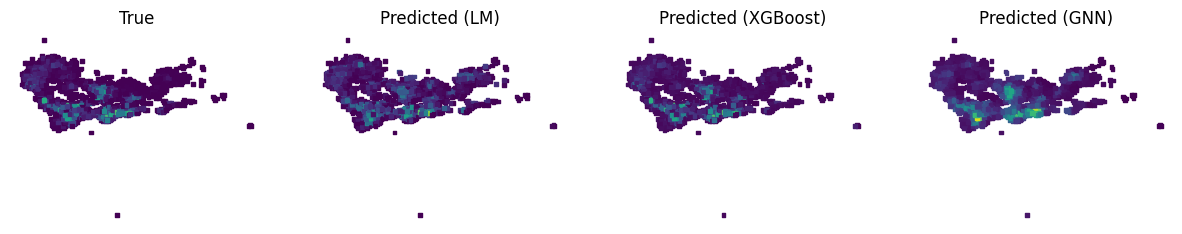

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 2.5))
ax[0].scatter(c['x'], c['y'], c=graph_data.y.reshape(-1), cmap='viridis', marker="s", s=7)
ax[0].set_title('True')
ax[0].set_axis_off()

ax[1].scatter(c['x'], c['y'], c=y_pred_lm.reshape(-1), cmap='viridis', marker="s", s=7)
ax[1].set_title('Predicted (LM)')
ax[1].set_axis_off()

ax[2].scatter(c['x'], c['y'], c=y_pred_xgb.reshape(-1), cmap='viridis', marker="s", s=7) # comment in after solving exercise 1
ax[2].set_title('Predicted (XGBoost)')
ax[2].set_axis_off()

ax[3].scatter(c['x'], c['y'], c=y_pred_gnn.detach().reshape(-1), cmap='viridis', marker="s", s=7)
ax[3].set_title('Predicted (GNN)')
ax[3].set_axis_off()

Are there spatial patterns visible in the prediction residuals / errors?

<ipython-input-53-4397307224f9>:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[2].scatter(c['x'], c['y'], c=y_pred_gnn.detach().reshape(-1) - y_true, cmap='viridis', marker="s", s=7)


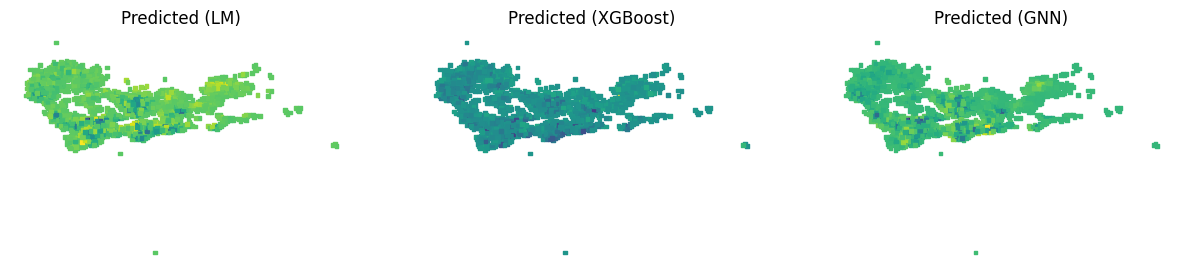

In [ ]:
y_true = graph_data.y.reshape(-1).numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].scatter(c['x'], c['y'], c=y_pred_lm.reshape(-1) - y_true, cmap='viridis', marker="s", s=7)
ax[0].set_axis_off()
ax[0].set_title('Predicted (LM)')

ax[1].scatter(c['x'], c['y'], c=y_pred_xgb.reshape(-1) - y_true, cmap='viridis', marker="s", s=7) # comment in after solving exercise 1
ax[1].set_title('Predicted (XGBoost)')
ax[1].set_axis_off()

ax[2].scatter(c['x'], c['y'], c=y_pred_gnn.detach().reshape(-1) - y_true, cmap='viridis', marker="s", s=7)
ax[2].set_title('Predicted (GNN)')
ax[2].set_axis_off()

## Out_of_Sample/ generalization performance

To get a more realistic idea of how well (or not) our models perform out-of-sample, let's split our data into **training**, **validation**, and **test** sets.

We use the **validation set** to tune the hyperparameters, monitor training progress and detect overfitting or perform early stopping, and the **test set** to evaluate the final model on unseen data. If we were to use the validation set to evaluate the final model, we would overestimate the predictive performance since the model is likely to perform disproportionately well on the data used to tune the hyperparameters. Having a reliable estimate of out-of-sample predictive performance is key to assessing applicability to real-world use cases.

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train (60%), validation (20%), and test (20%) set
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, c_train, c_val = train_test_split(X_train, y_train, c_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

Let's plot the train, validation and test set.

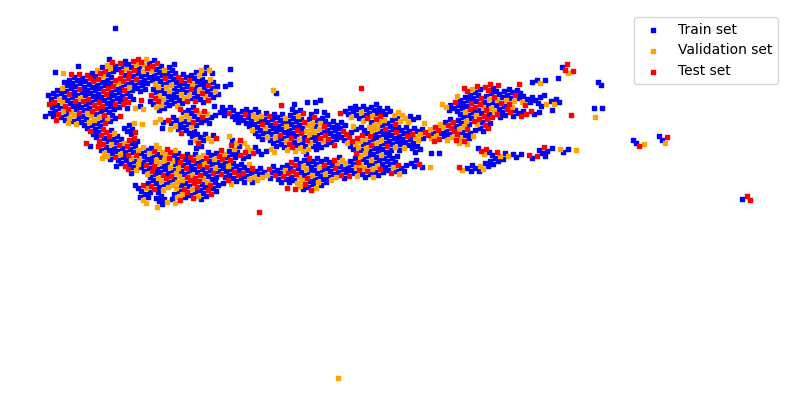

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(c_train['x'], c_train['y'], c='blue', marker="s", s=10, label="Train set")
ax.scatter(c_val['x'], c_val['y'], c='orange', marker="s", s=10, label="Validation set")
ax.scatter(c_test['x'], c_test['y'], c='red', marker="s", s=10, label="Test set")
ax.legend()
ax.set_axis_off()

Now, let's train all models again and evaluate them on unseen data.

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_train_lm = lm.predict(X_train)
y_pred_test_lm = lm.predict(X_test)

lm_train_r2 = r2_score(y_train, y_pred_train_lm)
lm_test_r2 = r2_score(y_test, y_pred_test_lm)
print(f"LM - Train R-squared: {lm_train_r2:.3f}")
print(f"LM - Test R-squared: {lm_test_r2:.3f}")


LM - Train R-squared: 0.404
LM - Test R-squared: 0.414


In [ ]:
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_val, y_val)])
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

xgb_train_r2 = r2_score(y_train, y_pred_train_xgb)
xgb_test_r2 = r2_score(y_test, y_pred_test_xgb)
print(f'XGBoost - Train R-squared: {xgb_train_r2:.3f}')
print(f'XGBoost - Test R-squared: {xgb_test_r2:.3f}')

XGBoost - Train R-squared: 0.978
XGBoost - Test R-squared: 0.066


We can inspect the training progress and see how the model performance changes over time with additional trees or training epochs to detect under- and overfitting.

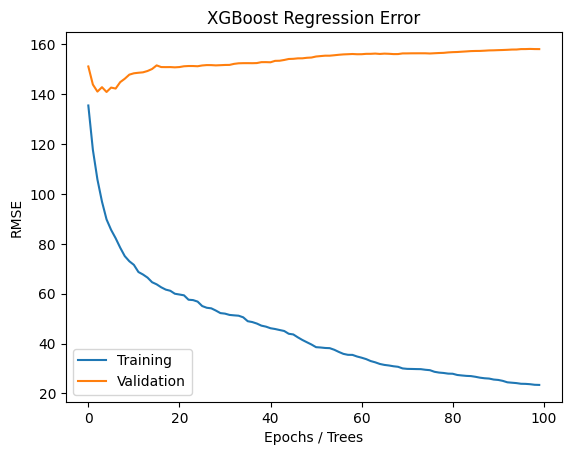

In [ ]:
# Retrieve training performance metrics
results = xgb_model.evals_result()
error_train = results['validation_0']['rmse']
error_test = results['validation_1']['rmse']

# Plot performance metrics
_, ax = plt.subplots(1)
epochs = len(error_train)
x_axis = range(0, epochs)
ax.plot(x_axis, error_train, label='Training')
ax.plot(x_axis, error_test, label='Validation')
ax.set_xlabel('Epochs / Trees')
ax.set_ylabel('RMSE')
ax.set_title('XGBoost Regression Error')
ax.legend()


We can clearly see that the training error continues to decrease, while the validation error starts to increase slightly after 10 trees, indicating a slight overfitting. Consequently, we could decrease the `n_estimators` hyperparameter to use only 10 trees or perform some form of regularization to mitigate the overfitting.

In [ ]:
torch.manual_seed(1886298579725472513) # some seed to ensure reproducibility

lr = 1e-1
n_epochs = 1000
print_freq = 100

losses_train = []
losses_val = []

c_train_t = torch.tensor(c_train.values, dtype=torch.float)
X_train_t = torch.tensor(X_train.values, dtype=torch.float)
y_train_t = torch.tensor(y_train.values, dtype=torch.float)

c_val_t = torch.tensor(c_val.values, dtype=torch.float)
X_val_t = torch.tensor(X_val.values, dtype=torch.float)
y_val_t = torch.tensor(y_val.values, dtype=torch.float)

c_test_t = torch.tensor(c_test.values, dtype=torch.float)
X_test_t = torch.tensor(X_test.values, dtype=torch.float)
y_test_t = torch.tensor(y_test.values, dtype=torch.float)

edge_index_train = knn_graph(c_train_t, k=k, loop=False)
edge_index_val = knn_graph(c_val_t, k=k, loop=False)
edge_index_test = knn_graph(c_test_t, k=k, loop=False)

graph_data_train = Data(x=X_train_t, y=y_train_t, edge_index=edge_index_train, pos=c_train_t)
graph_data_val = Data(x=X_val_t, y=y_val_t, edge_index=edge_index_val, pos=c_val_t)
graph_data_test = Data(x=X_test_t, y=y_test_t, edge_index=edge_index_test, pos=c_test_t)

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data_train.x.float(), graph_data_train.edge_index)
  optimizer.zero_grad()
  loss_train = loss_fun(graph_data_train.y.float().reshape(-1), out.reshape(-1))

  out_test = model(graph_data_val.x.float(), graph_data_val.edge_index)
  loss_val = loss_fun(graph_data_val.y.float().reshape(-1), out_test.reshape(-1))
  losses_train.append(loss_train.item())
  losses_val.append(loss_val.item())

  loss_train.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print(f'Train loss: {loss_train.item():.1f}, Validation loss: {loss_val.item():.1f}')

Train loss: 16027.0, Validation loss: 17519.7
Train loss: 15880.1, Validation loss: 17324.8
Train loss: 15692.6, Validation loss: 17328.0
Train loss: 15535.1, Validation loss: 17476.5
Train loss: 15541.1, Validation loss: 17704.4
Train loss: 15466.4, Validation loss: 17654.6
Train loss: 15631.6, Validation loss: 17977.6
Train loss: 15413.5, Validation loss: 17832.9
Train loss: 15308.1, Validation loss: 17785.5
Train loss: 15410.5, Validation loss: 18457.3


In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_train_gnn = model(graph_data_train.x.float(), graph_data_train.edge_index)
  y_pred_test_gnn = model(graph_data_test.x.float(), graph_data_test.edge_index)

gnn_train_r2 = r2_score(y_train, y_pred_train_gnn)
gnn_test_r2 = r2_score(y_test, y_pred_test_gnn)
print(f"GNN - Train R-squared: {gnn_train_r2:.3f}")
print(f"GNN - Test R-squared: {gnn_test_r2:.3f}")

GNN - Train R-squared: 0.382
GNN - Test R-squared: 0.282


Let's visualize the training and validation loss again to detect under- and overfitting.

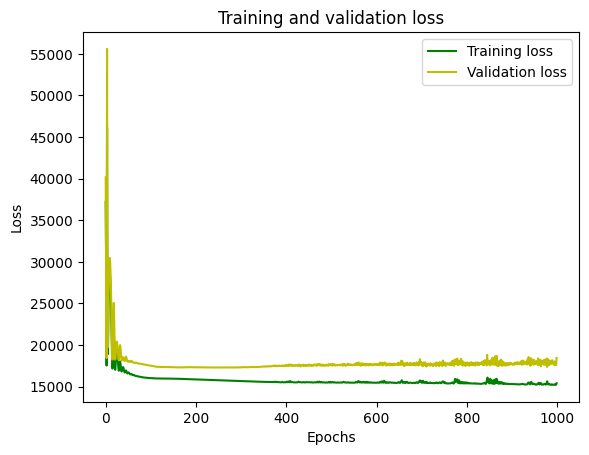

In [ ]:
plt.clf()
epochs = list(range(n_epochs))
plt.plot(epochs, losses_train, 'g', label='Training loss')
plt.plot(epochs, losses_val, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


We see a similar pattern as before: The validation loss increases again after some time, indicating that the out-of-sample predictive performance of our model would be better if we had stopped the training earlier.

## Discussion

In [ ]:
r_squared = {
    'Linear reg.': {
        'Train': lm_train_r2,
        'Test': lm_test_r2,
        },
    'XGBoost': {
        'Train': xgb_train_r2,
        'Test': xgb_test_r2,
        },
    'GNN': {
        'Train': gnn_train_r2,
        'Test': gnn_test_r2,
        },
}

pd.DataFrame(r_squared).round(2)

,Linear reg.,XGBoost,GNN
Train,0.40,0.98,0.38
Test,0.41,0.07,0.28


<a name="take-aways"></a>

### What are the main take-aways from our model comparison?

* **Linear vs. non-parametric relationships:** A machine learning model does not necessarily outperform traditional statistical models such as linear regression. In particular, if the relationship between the features and the outcome is approximately linear, a linear regression will most likely outperform machine learning models and provide more reliable results (the risk of overfitting is much lower due to the strong parametric assumptions made beforehand). However, if the relationship is characterized by nonlinearities and threshold effects, a machine learning model is often the better choice.
* **Model complexity:** A deep neural network will not always outperform simpler models. Especially when training data is scarce, less complex models, which are faster to train and require less training data, have an advantage. Also, on tabular data, tree-based models such as RandomForest, XGBoost, or LightGBM often (still) outperform neural networks. Our model comparison results here are preliminary, as we used only a fraction of the available data and neglected other features of interest that may have a non-linear impact (e.g. local bicycle infrastructure) and temporal patterns in the data.
* **Choose your hyperparameters wisely:** Always evaluate your machine learning model on unseen data to avoid overoptimistic performance estimates. Especially for neural networks, use a dedicated validation set to optimize your hyperparameters and detect overfitting.


### Can we improve the model performance further?

<a name="task-GNN-tune"></a>


Let's try to improve the predictive performance (Test R2) of the GNN above by tuning its hyperparameters and implement early stopping<sup>1</sup>:
* **Learning rate**: Find a good balance between fast convergence during training and a stable detection of minima (e.g. validation loss should not jump around)
* **Epochs**: The number of epochs for the GNN determines how many times the entire training dataset is passed through the network to find the optimal weights (intuition: too few epochs may not be sufficient to capture all relevant information in the training data and result in underfitting, too many epochs may result in overfitting)
* **Early stopping**: A good way to find a reasonable number of epochs is to stop training when the validation error stops decreasing or even increases again, a technique called early stopping.
* **Model complexity and architecture**: Generally said, the more parameters / weights a model has, the more information it can potentially capture. Different architectures help to capture different types of data (e.g. recurrent layers are great for temporal data, convolution layers are great for spatial data or images, attention layers are great for relational and sequential data). Try to increase the model complexity to improve the predictive performance, without running into the overfitting regime. For the GNN you can, for example, increase the number of neurons in the hidden layer (`hidden_dim`) or try a more complex model architecture (e.g. `GATConv` or `SAGEConv`).


<sup>1</sup> *The goal of this task is to get a feeling for how different hyperparameters influence the training progress and how overfitting can be spotted and mitigated. There is no need to actually find the best performing hyperparameters - also considering that we intentionally use only a subset of the data, a relatively simple model architecture and a simplified task to ensure fast training. In this sense, the task is rather exploratory and does not have a single solution.*

In [ ]:
torch.manual_seed(1886298579725472513) # some seed to ensure reproducibility

lr = 1e-3
n_epochs = 1000
print_freq = 100

losses_train = []
losses_val = []

c_train_t = torch.tensor(c_train.values, dtype=torch.float)
X_train_t = torch.tensor(X_train.values, dtype=torch.float)
y_train_t = torch.tensor(y_train.values, dtype=torch.float)

c_val_t = torch.tensor(c_val.values, dtype=torch.float)
X_val_t = torch.tensor(X_val.values, dtype=torch.float)
y_val_t = torch.tensor(y_val.values, dtype=torch.float)

c_test_t = torch.tensor(c_test.values, dtype=torch.float)
X_test_t = torch.tensor(X_test.values, dtype=torch.float)
y_test_t = torch.tensor(y_test.values, dtype=torch.float)

edge_index_train = knn_graph(c_train_t, k=k, loop=False)
edge_index_val = knn_graph(c_val_t, k=k, loop=False)
edge_index_test = knn_graph(c_test_t, k=k, loop=False)

graph_data_train = Data(x=X_train_t, y=y_train_t, edge_index=edge_index_train, pos=c_train_t)
graph_data_val = Data(x=X_val_t, y=y_val_t, edge_index=edge_index_val, pos=c_val_t)
graph_data_test = Data(x=X_test_t, y=y_test_t, edge_index=edge_index_test, pos=c_test_t)

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data_train.x.float(), graph_data_train.edge_index)
  optimizer.zero_grad()
  loss_train = loss_fun(graph_data_train.y.float().reshape(-1), out.reshape(-1))

  out_test = model(graph_data_val.x.float(), graph_data_val.edge_index)
  loss_val = loss_fun(graph_data_val.y.float().reshape(-1), out_test.reshape(-1))
  losses_train.append(loss_train.item())
  losses_val.append(loss_val.item())

  loss_train.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print(f'Train loss: {loss_train.item():.1f}, Validation loss: {loss_val.item():.1f}')

Train loss: 20466.7, Validation loss: 21181.2
Train loss: 17186.2, Validation loss: 18230.6
Train loss: 16913.8, Validation loss: 18146.0
Train loss: 16642.3, Validation loss: 18069.7
Train loss: 16409.9, Validation loss: 17994.5
Train loss: 16229.0, Validation loss: 17913.5
Train loss: 16104.7, Validation loss: 17805.5
Train loss: 16028.5, Validation loss: 17718.0
Train loss: 15991.0, Validation loss: 17650.7
Train loss: 15972.0, Validation loss: 17605.1


In [ ]:
with torch.no_grad():
  model.eval()
  y_pred_train_gnn = model(graph_data_train.x.float(), graph_data_train.edge_index)
  y_pred_test_gnn = model(graph_data_test.x.float(), graph_data_test.edge_index)

gnn_train_r2 = r2_score(y_train, y_pred_train_gnn)
gnn_test_r2 = r2_score(y_test, y_pred_test_gnn)
print(f"GNN - Train R-squared: {gnn_train_r2:.3f}")
print(f"GNN - Test R-squared: {gnn_test_r2:.3f}")

GNN - Train R-squared: 0.368
GNN - Test R-squared: 0.325


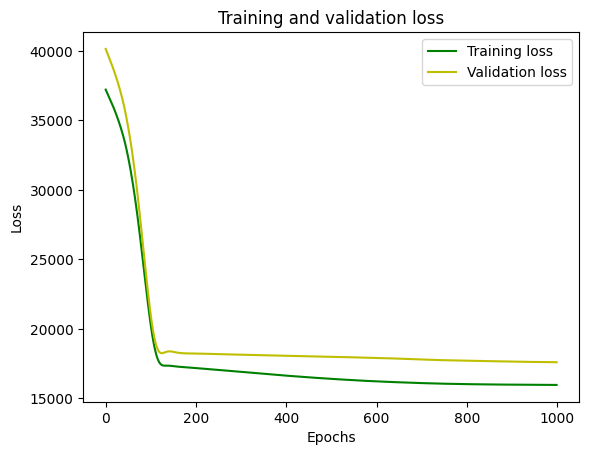

In [ ]:
plt.clf()
epochs = list(range(n_epochs))
plt.plot(epochs, losses_train, 'g', label='Training loss')
plt.plot(epochs, losses_val, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
######### Learning rate & epochs #########
"""
    There is not one single solution to this problem.
    The number of epochs should be high enough that the loss / error converges, but not as high that it starts to increase again.
    The learning rate should be small enough that the model finds the minima of the loss function and stays there, not jumping around.
    On the other hand, it should be large enough that the model doesn't get stuck in bad local minima or still hasn't found a minimum after all training epochs.
    It is important that the learning rate and number of epochs go well together, e.g. more epochs may allow for a smaller learning rate.
    For the example here, a learning rate of 1e-4 works well with 2,000 epochs or a learning rate of 1e-3 with 1,000 epochs.
"""

######### Early stopping #########

# See below for a reference pseudocode how early stopping can be implemented for PyTorch networks:

# Abort after how many epochs of consecutive no improvements in model loss
early_stopping_patience = 3

# Keep track of the best loss and best model weights with the lowest loss
best_loss = np.inf
best_model = None
patience_counter = 0

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')

    loss_val = lambda to_implement: None # train and validation of model as above

    if loss_val < best_loss:
        best_loss = loss_val
        patience_counter = 0
        best_model = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        break


######### Model architecture #########

# To try out a GATConv or SAGEConv, just change the graph layers of the model architecture, e.g.:
class GCN(nn.Module):
    def __init__(self, num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(num_features_in, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)

Epoch 1


TypeError: '<' not supported between instances of 'function' and 'float'

For the XGBoost model, let's try to perform a more structured, exhaustive hyperparameter optimization. The most popular approaches are the so-called random search and the grid search. You define a set of possible hyperparameter values, and then either all possible combinations (grid search) or a random subset of combinations is tried (random search). The evaluation of the hyperparameters is typically done by k-fold cross-validation rather than on a dedicated validation set. Although this kind of structured cross-validated hyperparameter search is also possible for deep neural networks, it is rarely used in practice due to the long training time and high computational cost. Instead, a training, validation, and test split is performed, and a less exhaustive hyperparameter search is performed using the validation set.
* Implement a random hyperparameter search for `max_depth`, `n_estimators`, and `learning_rate` using sklear's `RandomizedSearchCV` and identify the best performing hyperparameters

In [ ]:
# Hyperparameter optimization for XGBoost

from sklearn import model_selection

hyperparameter_tuning_space = {
    'max_depth': range(4, 10, 1),
    'learning_rate': [0.001, 0.01],
    'n_estimators': range(100, 500, 100),
}

# For simplicity, we will perform k-fold cross-validation on the training set to determine the best hyperparameters and ignore the validation set for the moment.
clf = model_selection.RandomizedSearchCV(
    estimator=xgb_model,
    n_iter=5,
    param_distributions=hyperparameter_tuning_space,
    verbose=3,
    cv=3,
    return_train_score=True,
    random_state=0,
)

clf.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_val, y_val)])

print(f'Best hyperparameters: {clf.best_params_}')
print(f'Corresponding score r: {clf.best_score_:.3f}')


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=(train=0.666, test=0.365) total time=   2.3s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=(train=0.657, test=0.361) total time=   3.1s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=200;, score=(train=0.681, test=0.306) total time=   0.2s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=(train=0.093, test=0.063) total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=(train=0.095, test=0.060) total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=100;, score=(train=0.098, test=0.067) total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=(train=0.660, test=0.390) total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=(train=0.653, test=0.345) total time=   0.2s
[CV 3/3] 

Great, we increased the out-of-sample R-squared from about 0.13 to about 0.32. Note that the test data is different (before we used a test-train split, here we used k-fold cross-validation), but given the large increase in R-squared, we expect the tuned model to perform much better on the old test set as well.

### Saving the Model
Now that we have optimized the hyperparameters and validated that the model performs well on unseen data, let's save the model for later.

In [ ]:
model_dir = Path('/content/models')
model_dir.mkdir(parents=True, exist_ok=True)
model_file = os.path.join(model_dir, 'best_model.pth')

# save only trained weights using state_dict() (not pickle full Python object)
torch.save(model.state_dict(), model_file)

print('Model successfully saved to {}'.format(model_file))

Model successfully saved to /content/models/best_model.pth


<a name="limitations"></a>

## Limitations
* Both of our models are constrained by the data we provide to it. We have used subsets of the data in this tutorial so that it runs within a reasonable amount of time. Using all the data may or may not lead to better results.
* If our goal is to improve climate change-related outcomes by promoting greener modes of transportation, we should not assume that bikers and car-users have the same travelling patterns even though it does feel like there is a strong relationship between the two.

For many applications it is important to understand how a machine learning model comes to a decision. For tree-based models, [SHAP](https://shap.readthedocs.io/en/latest/index.html) values are a great option to examine the contribution of each feature to the prediction for each individual sample. The sum of SHAP values for a sample is equal to the predicted value, as such SHAP values can be viewed as a decomposition of the predicted value.

High SHAP values indicate that the feature increases the prediction value. In our example, this would mean that a POI feature is associated with more bike trips ending at a location.

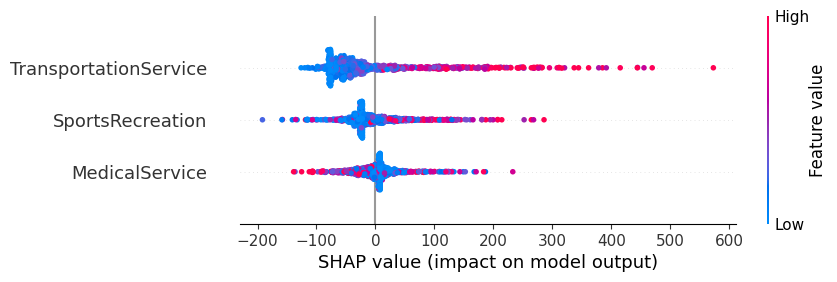

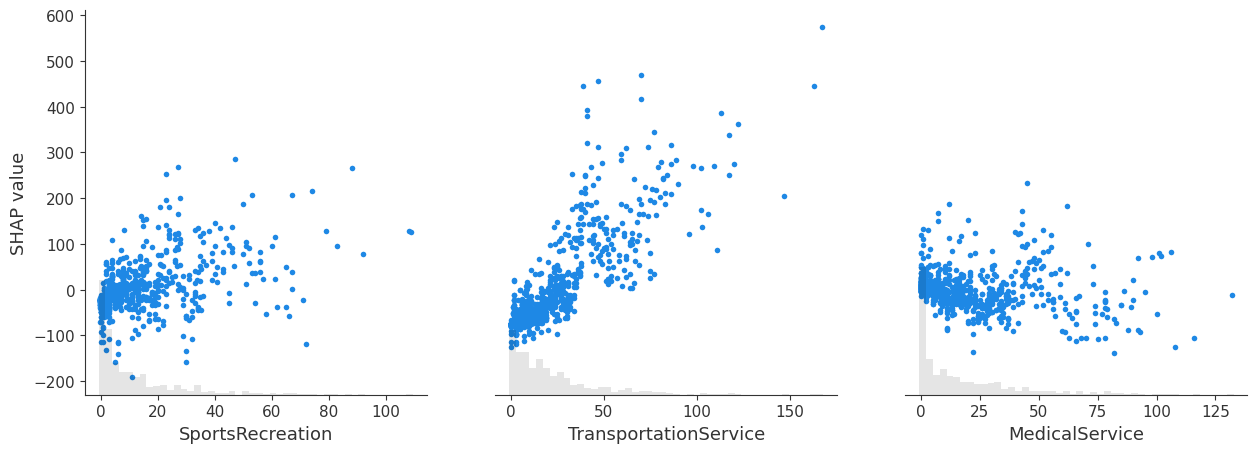

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model, feature_names=X.columns)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)
shap.plots.scatter(shap_values)

We see that higher densities of sports and transport POIs are associated with more bike trips, while high densities of medical POIs tend to be associated with fewer bike trips. Intuitively, this makes sense, since a trip to the doctor might be less likely to be biked than a trip to a sports facility or a trip to a transit station.

Developing accurate models of the relationship between POIs and trip densities allows us to understand bike-sharing usage patterns. This patterns can be used to make sure that there are enough bikes at stands to meet demand. It can also inform where to set up new bike stands. Analyzing the POIs and geographic regions with low trip densities may reveal lack of biking infrastructure such as bike lanes, bike stands, etc. or other issues that need to be addressed.

<a name="task-policy-advice"></a>
Instead of looking only at areas where bike stands already exist, let's look at other areas and use our fitted model to estimate where a new bike stand is likely to attract the most cyclists.
Feel free to use the model you are most comfortable with for this task.

In [ ]:
# SOLUTION

# Determine locations where no bike stands yet exist / no trips end
new_locations = poi_counts[~poi_counts.index.isin(trips.index)]

# Predict number of trips that might end there if new bike stands were installed, given the local POI density
new_locations['trip_count_pred'] = xgb_model.predict(new_locations[['SportsRecreation', 'TransportationService', 'MedicalService']])

# Visualize potential of locations
new_locations.h3.h3_to_geo_boundary().explore('trip_count_pred')

<ipython-input-71-5b15a2a36274>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_locations['trip_count_pred'] = xgb_model.predict(new_locations[['SportsRecreation', 'TransportationService', 'MedicalService']])


Great! There are a number of locations for new bike racks where we expect a large number of trips to end.

Some of them are close to existing bike racks. Let's take a look at which ones are not within walking distance of existing bike racks and highlight them in our policy recommendations.

In [ ]:
# Identify locations which are close to existing bike racks
locations_close_to_existing_stands = trips.h3.hex_ring()['h3_hex_ring'].explode().values

# Exclude these locations so that only locations far from existing bike racks remain
new_locations_away_from_existing_stands = new_locations[~new_locations.index.isin(locations_close_to_existing_stands)]

# Visualize potential of these locations
new_locations_away_from_existing_stands.h3.h3_to_geo_boundary().explore('trip_count_pred')